# Fish Muscle Stress Relaxation

Fit relaxation of fish muscle data with generalized and fractional Maxwell models.

**Data:** examples/data/relaxation/biological/stressrelaxation_fishmuscle_data.csv


In [1]:
# Google Colab compatibility - uncomment if running in Colab
# !pip install -q rheojax
# from google.colab import drive
# drive.mount('/content/drive')


## Setup and Imports

In [2]:
# Configure matplotlib for inline plotting in VS Code/Jupyter
%matplotlib inline

import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from rheojax.core.data import RheoData
from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models import FractionalMaxwellModel, GeneralizedMaxwell, HerschelBulkley
from rheojax.pipeline.base import Pipeline
from rheojax.transforms.mastercurve import Mastercurve

jax, jnp = safe_import_jax()
verify_float64()
np.set_printoptions(precision=4, suppress=True)
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11
warnings.filterwarnings('ignore', category=RuntimeWarning)

def r2_complex(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    ss_res = np.sum(np.abs(y_true - y_pred) ** 2)
    ss_tot = np.sum(np.abs(y_true - np.mean(y_true)) ** 2)
    return float(1 - ss_res / ss_tot)

def mpe(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    return float(np.mean(np.abs(y_true - y_pred) / np.maximum(np.abs(y_true), 1e-12)) * 100)
import os
import sys

import arviz as az

# Shared plotting utilities
sys.path.insert(0, os.path.join(os.path.dirname(os.path.abspath("")), ".."))
from utils.plotting_utils import display_arviz_diagnostics


## Load relaxation data

In [3]:
DATA_DIR = Path.cwd().parent / 'data' / 'relaxation' / 'biological'
df = pd.read_csv(DATA_DIR / 'stressrelaxation_fishmuscle_data.csv', sep='	')
df.columns = df.columns.str.strip()

# Columns: Time (s), Relaxation Modulus (Pa)
t = df.iloc[:,0].to_numpy()
sigma = df.iloc[:,1].to_numpy()

data = RheoData(x=t, y=sigma, x_units='s', y_units='Pa', domain='relaxation')
print(df.head())


     Time  Relaxation Modulus
0  0.0139             33600.0
1  0.0149             33243.0
2  0.0159             31100.0
3  0.0169             30900.0
4  0.0180             31700.0


## Fit relaxation models

In [4]:
gm = GeneralizedMaxwell(n_modes=5, modulus_type='tensile')
gm.fit(t, sigma, test_mode='relaxation', use_log_residuals=True, use_multi_start=True)
gm_pred = gm.predict(t)
gm_r2 = gm.score(t, sigma)

fm = FractionalMaxwellModel()
fm.fit(t, sigma, test_mode='relaxation', use_log_residuals=True)
fm_pred = fm.predict(t, test_mode='relaxation')
fm_r2 = r2_complex(sigma, fm_pred)

print({'gm_r2': gm_r2, 'fm_r2': fm_r2})


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=11 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=1.083266s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=20 | final_cost=4.9715e+06 | elapsed=1.083s | final_gradient_norm=3.5796e+10


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=11 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.398813s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=20 | final_cost=4.9715e+06 | elapsed=0.399s | final_gradient_norm=3.5796e+10


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=9 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=1.089346s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=17 | final_cost=1.1825e+07 | elapsed=1.089s | final_gradient_norm=9.1806e+10


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=4 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


[WARNING] Inner optimization loop hit iteration limit inner_iterations=100 | actual_reduction=-1


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=3.456220s


INFO:nlsq.least_squares:Convergence reason=Inner optimization loop exceeded maximum iterations. | iterations=1 | final_cost=197.7376 | elapsed=3.456s | final_gradient_norm=nan


ERROR:rheojax.utils.optimization:Failed to compute covariance from Jacobian
Traceback (most recent call last):
  File "/Users/b80985/Projects/rheojax/rheojax/utils/optimization.py", line 87, in compute_covariance_from_jacobian
    U, s, VT = np.linalg.svd(jac, full_matrices=False)
               ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/numpy/linalg/_linalg.py", line 1862, in svd
    u, s, vh = gufunc(a, signature=signature)
               ~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/numpy/linalg/_linalg.py", line 172, in _raise_linalgerror_svd_nonconvergence
    raise LinAlgError("SVD did not converge")
numpy.linalg.LinAlgError: SVD did not converge


{'gm_r2': 0.9996992915644162, 'fm_r2': -1.5374631426677596}


## Plot relaxation fits

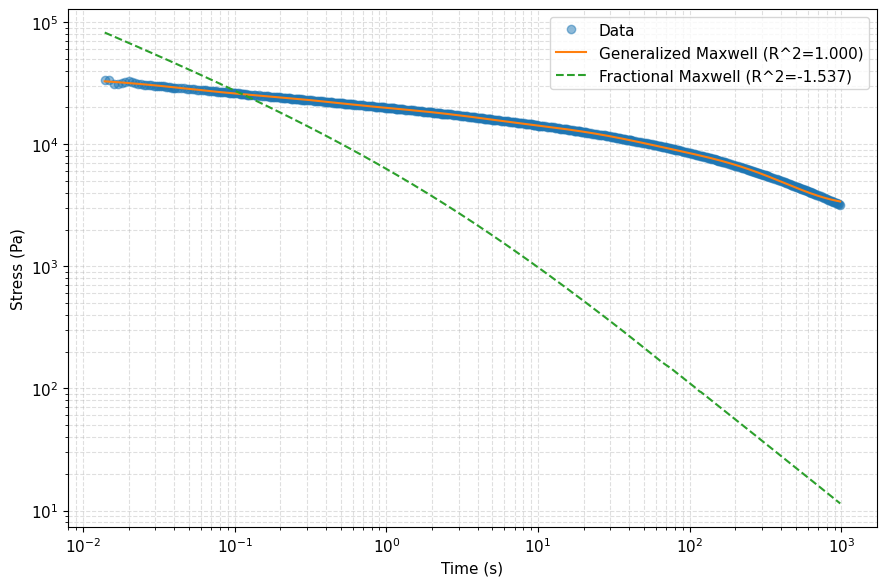

In [5]:
fig, ax = plt.subplots(figsize=(9, 6))
ax.loglog(t, sigma, 'o', label='Data', alpha=0.5)
ax.loglog(t, gm_pred, '-', label=f'Generalized Maxwell (R^2={gm_r2:.3f})')
ax.loglog(t, fm_pred, '--', label=f'Fractional Maxwell (R^2={fm_r2:.3f})')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Stress (Pa)')
ax.grid(True, which='both', ls='--', alpha=0.4)
ax.legend()
plt.tight_layout()
display(fig)
plt.close(fig)

## Bayesian workflow (NLSQ → best model → NUTS diagnostics)

In [6]:
# Helper functions for workflow
if 'r2_complex' not in globals():
    def r2_complex(y_true, y_pred):
        """Compute R² for complex-valued data."""
        y_true = np.asarray(y_true)
        y_pred = np.asarray(y_pred)
        ss_res = np.sum(np.abs(y_true - y_pred) ** 2)
        ss_tot = np.sum(np.abs(y_true - np.mean(y_true)) ** 2)
        return 1 - ss_res / ss_tot

if '_coerce_pred' not in globals():
    def _coerce_pred(pred):
        """Convert 2-column real array to complex if needed."""
        arr = np.asarray(pred)
        if arr.ndim == 2 and arr.shape[1] == 2 and not np.iscomplexobj(arr):
            arr = arr[:, 0] + 1j * arr[:, 1]
        return arr

NUTS_CONFIG = dict(num_chains=1, num_warmup=200, num_samples=500)  # Fast demo mode


In [7]:
def _detect_datasets():
    """Auto-detect datasets from global variables."""
    datasets = []
    if 'G_star' in globals() and 'omega' in globals():
        datasets.append({
            'X': omega, 'y': G_star, 'test_mode': 'oscillation',
            'x_label': 'Angular frequency (rad/s)', 'y_label': 'Complex modulus',
        })
    elif 'Gp' in globals() and 'Gpp' in globals() and 'omega' in globals():
        datasets.append({
            'X': omega, 'y': Gp + 1j * Gpp, 'test_mode': 'oscillation',
            'x_label': 'Angular frequency (rad/s)', 'y_label': 'Complex modulus',
        })
    if 'master' in globals() and hasattr(master, 'x') and hasattr(master, 'y'):
        test_mode = master.metadata.get('test_mode', 'oscillation') if hasattr(master, 'metadata') else 'oscillation'
        datasets.append({
            'X': master.x, 'y': master.y, 'test_mode': test_mode,
            'x_label': 'Shifted frequency', 'y_label': 'Mastercurve modulus',
        })
    if 't' in globals() and 'G' in globals():
        datasets.append({'X': t, 'y': G, 'test_mode': 'relaxation', 'x_label': 'Time (s)', 'y_label': 'Relaxation modulus'})
    if 't' in globals() and 'E_t' in globals():
        datasets.append({'X': t, 'y': E_t, 'test_mode': 'relaxation', 'x_label': 'Time (s)', 'y_label': 'Relaxation modulus'})
    if 't' in globals() and 'sigma' in globals():
        datasets.append({'X': t, 'y': sigma, 'test_mode': 'relaxation', 'x_label': 'Time (s)', 'y_label': 'Stress (Pa)'})
    if 't' in globals() and 'J' in globals():
        datasets.append({'X': t, 'y': J, 'test_mode': 'creep', 'x_label': 'Time (s)', 'y_label': 'Creep compliance'})
    if 'all_df' in globals() and hasattr(all_df, 'columns') and 'phi' in all_df.columns:
        for phi, frame in all_df.groupby('phi'):
            x_vals = frame.iloc[:, 0].to_numpy()
            y_vals = frame.iloc[:, 1].to_numpy()
            datasets.append({
                'X': x_vals, 'y': y_vals, 'test_mode': 'rotation',
                'x_label': f'Shear rate 1/s (phi={phi})', 'y_label': 'Stress (Pa)', 'label': f'phi={phi}',
            })
    if not datasets:
        raise ValueError('No datasets detected; ensure data variables are defined.')
    return datasets

def _collect_candidate_models():
    """Collect candidate models from global variables."""
    if 'candidates' in globals() and isinstance(candidates, (list, tuple)) and candidates:
        return candidates
    models = []
    for name, obj in globals().items():
        if isinstance(obj, type):
            continue
        if hasattr(obj, 'fit_bayesian') and hasattr(obj, 'predict'):
            models.append((name, obj))
    if not models:
        raise ValueError('No candidate models found; define models before running.')
    return models

datasets = _detect_datasets()
model_entries = _collect_candidate_models()
print(f"Found {len(datasets)} dataset(s) and {len(model_entries)} model(s)")


Found 1 dataset(s) and 2 model(s)


In [8]:
# NLSQ fitting loop - fit all models to all datasets
all_fits = {}  # {dataset_idx: [fit_records]}

for ds_idx, ds in enumerate(datasets):
    fits = []
    for name, model in model_entries:
        fitted_model = model
        fit_kwargs = {'test_mode': ds['test_mode'], 'use_log_residuals': True}
        try:
            fitted_model.fit(ds['X'], ds['y'], **fit_kwargs)
        except TypeError:
            fit_kwargs.pop('use_log_residuals', None)
            try:
                fitted_model.fit(ds['X'], ds['y'], **fit_kwargs)
            except Exception as exc:
                print(f"Skipping {name} due to fit error: {exc}")
                continue
        except Exception as exc:
            print(f"Skipping {name} due to fit error: {exc}")
            continue

        predict_kwargs = {'test_mode': ds['test_mode']} if 'test_mode' in fit_kwargs else {}
        try:
            pred = _coerce_pred(fitted_model.predict(ds['X'], **predict_kwargs))
        except Exception as exc:
            print(f"Skipping {name} due to predict error: {exc}")
            continue

        try:
            r2_val = r2_complex(ds['y'], pred) if np.iscomplexobj(ds['y']) else fitted_model.score(ds['X'], ds['y'])
        except Exception as exc:
            print(f"Skipping {name} due to scoring error: {exc}")
            continue

        fits.append({'name': name, 'model': fitted_model, 'pred': pred, 'r2': float(r2_val)})

    fits.sort(key=lambda rec: rec['r2'], reverse=True)
    all_fits[ds_idx] = fits
    if fits:
        print(f"Dataset {ds_idx} ranking: {[(r['name'], round(r['r2'], 3)) for r in fits]}")
    else:
        print(f"Dataset {ds_idx}: No successful fits")


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=11 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.435651s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=20 | final_cost=4.9715e+06 | elapsed=0.436s | final_gradient_norm=3.5796e+10


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=11 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.504837s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=20 | final_cost=4.9715e+06 | elapsed=0.505s | final_gradient_norm=3.5796e+10


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=9 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.707116s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=17 | final_cost=1.1825e+07 | elapsed=0.707s | final_gradient_norm=9.1806e+10


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=4 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


[WARNING] Inner optimization loop hit iteration limit inner_iterations=100 | actual_reduction=-1


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=2.013574s


INFO:nlsq.least_squares:Convergence reason=Inner optimization loop exceeded maximum iterations. | iterations=1 | final_cost=197.7376 | elapsed=2.014s | final_gradient_norm=nan


ERROR:rheojax.utils.optimization:Failed to compute covariance from Jacobian
Traceback (most recent call last):
  File "/Users/b80985/Projects/rheojax/rheojax/utils/optimization.py", line 87, in compute_covariance_from_jacobian
    U, s, VT = np.linalg.svd(jac, full_matrices=False)
               ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/numpy/linalg/_linalg.py", line 1862, in svd
    u, s, vh = gufunc(a, signature=signature)
               ~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/numpy/linalg/_linalg.py", line 172, in _raise_linalgerror_svd_nonconvergence
    raise LinAlgError("SVD did not converge")
numpy.linalg.LinAlgError: SVD did not converge


Dataset 0 ranking: [('gm', 1.0), ('fm', -1.537)]


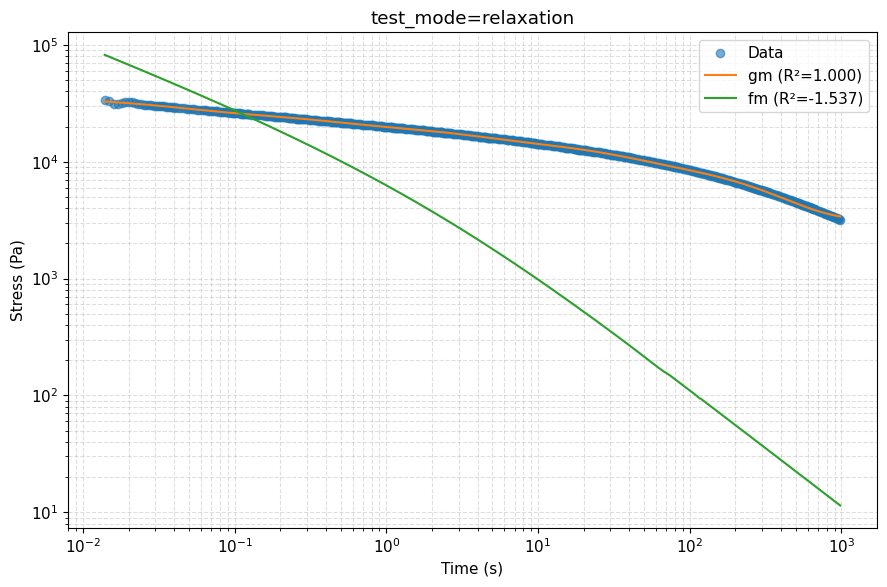

  0%|          | 0/700 [00:00<?, ?it/s]

warmup:   0%|          | 1/700 [00:01<19:06,  1.64s/it, 1 steps of size 1.95e+00. acc. prob=0.00]

warmup:   3%|▎         | 21/700 [00:01<00:41, 16.48it/s, 127 steps of size 1.01e-03. acc. prob=0.75]

warmup:   5%|▌         | 38/700 [00:01<00:20, 31.66it/s, 255 steps of size 8.81e-04. acc. prob=0.80]

warmup:   7%|▋         | 51/700 [00:01<00:15, 42.72it/s, 63 steps of size 2.79e-04. acc. prob=0.81] 

warmup:  10%|█         | 70/700 [00:02<00:09, 64.43it/s, 63 steps of size 1.56e-03. acc. prob=0.84]

warmup:  12%|█▏        | 85/700 [00:02<00:07, 77.08it/s, 127 steps of size 8.06e-04. acc. prob=0.84]

warmup:  14%|█▍        | 99/700 [00:02<00:06, 87.88it/s, 255 steps of size 9.18e-04. acc. prob=0.85]

warmup:  17%|█▋        | 120/700 [00:02<00:05, 114.08it/s, 127 steps of size 2.29e-02. acc. prob=0.86]

warmup:  19%|█▉        | 136/700 [00:02<00:04, 123.76it/s, 127 steps of size 2.72e-02. acc. prob=0.87]

warmup:  22%|██▏       | 155/700 [00:02<00:03, 139.78it/s, 127 steps of size 5.83e-03. acc. prob=0.86]

warmup:  25%|██▍       | 172/700 [00:02<00:04, 127.09it/s, 127 steps of size 5.12e-02. acc. prob=0.87]

warmup:  27%|██▋       | 187/700 [00:02<00:04, 118.42it/s, 127 steps of size 5.36e-02. acc. prob=0.87]

sample:  29%|██▉       | 204/700 [00:03<00:03, 129.14it/s, 127 steps of size 3.60e-02. acc. prob=0.75]

sample:  31%|███▏      | 219/700 [00:03<00:03, 134.22it/s, 127 steps of size 3.60e-02. acc. prob=0.87]

sample:  34%|███▎      | 236/700 [00:03<00:03, 142.10it/s, 127 steps of size 3.60e-02. acc. prob=0.86]

sample:  36%|███▌      | 251/700 [00:03<00:03, 128.83it/s, 127 steps of size 3.60e-02. acc. prob=0.88]

sample:  38%|███▊      | 266/700 [00:03<00:03, 132.03it/s, 127 steps of size 3.60e-02. acc. prob=0.88]

sample:  40%|████      | 280/700 [00:03<00:03, 130.55it/s, 127 steps of size 3.60e-02. acc. prob=0.89]

sample:  43%|████▎     | 298/700 [00:03<00:02, 143.66it/s, 127 steps of size 3.60e-02. acc. prob=0.89]

sample:  45%|████▍     | 313/700 [00:03<00:02, 142.54it/s, 127 steps of size 3.60e-02. acc. prob=0.89]

sample:  47%|████▋     | 329/700 [00:03<00:02, 145.11it/s, 127 steps of size 3.60e-02. acc. prob=0.88]

sample:  49%|████▉     | 344/700 [00:04<00:02, 139.86it/s, 127 steps of size 3.60e-02. acc. prob=0.89]

sample:  51%|█████▏    | 359/700 [00:04<00:02, 115.98it/s, 255 steps of size 3.60e-02. acc. prob=0.89]

sample:  53%|█████▎    | 374/700 [00:04<00:02, 121.56it/s, 127 steps of size 3.60e-02. acc. prob=0.89]

sample:  55%|█████▌    | 387/700 [00:04<00:02, 114.27it/s, 127 steps of size 3.60e-02. acc. prob=0.89]

sample:  57%|█████▋    | 402/700 [00:04<00:02, 122.27it/s, 127 steps of size 3.60e-02. acc. prob=0.89]

sample:  60%|██████    | 423/700 [00:04<00:01, 144.98it/s, 127 steps of size 3.60e-02. acc. prob=0.90]

sample:  63%|██████▎   | 439/700 [00:04<00:02, 124.44it/s, 127 steps of size 3.60e-02. acc. prob=0.89]

sample:  65%|██████▍   | 453/700 [00:04<00:01, 126.81it/s, 15 steps of size 3.60e-02. acc. prob=0.90] 

sample:  68%|██████▊   | 474/700 [00:05<00:01, 147.80it/s, 127 steps of size 3.60e-02. acc. prob=0.90]

sample:  71%|███████   | 494/700 [00:05<00:01, 159.98it/s, 127 steps of size 3.60e-02. acc. prob=0.90]

sample:  73%|███████▎  | 511/700 [00:05<00:01, 141.48it/s, 127 steps of size 3.60e-02. acc. prob=0.90]

sample:  75%|███████▌  | 526/700 [00:05<00:01, 138.91it/s, 143 steps of size 3.60e-02. acc. prob=0.90]

sample:  78%|███████▊  | 544/700 [00:05<00:01, 149.18it/s, 127 steps of size 3.60e-02. acc. prob=0.90]

sample:  80%|████████  | 560/700 [00:05<00:00, 150.16it/s, 127 steps of size 3.60e-02. acc. prob=0.90]

sample:  82%|████████▏ | 576/700 [00:05<00:00, 152.82it/s, 127 steps of size 3.60e-02. acc. prob=0.90]

sample:  85%|████████▍ | 592/700 [00:05<00:00, 139.40it/s, 127 steps of size 3.60e-02. acc. prob=0.90]

sample:  87%|████████▋ | 607/700 [00:06<00:00, 119.38it/s, 63 steps of size 3.60e-02. acc. prob=0.90] 

sample:  89%|████████▊ | 620/700 [00:06<00:00, 108.91it/s, 127 steps of size 3.60e-02. acc. prob=0.90]

sample:  91%|█████████ | 637/700 [00:06<00:00, 122.20it/s, 127 steps of size 3.60e-02. acc. prob=0.90]

sample:  94%|█████████▎| 655/700 [00:06<00:00, 135.42it/s, 63 steps of size 3.60e-02. acc. prob=0.90] 

sample:  97%|█████████▋| 677/700 [00:06<00:00, 157.19it/s, 127 steps of size 3.60e-02. acc. prob=0.90]

sample: 100%|██████████| 700/700 [00:06<00:00, 106.36it/s, 63 steps of size 3.60e-02. acc. prob=0.90] 

Dataset 0: Bayesian inference complete for gm


In [9]:
# Bayesian inference on best model per dataset
def _plot_data_and_fits(ds, fits):
    """Plot data with model fits overlay."""
    fig, ax = plt.subplots(figsize=(9, 6))
    X_plot, y_true = ds['X'], ds['y']
    if np.iscomplexobj(y_true):
        x_axis = X_plot / (2 * np.pi) if ds['test_mode'] == 'oscillation' else X_plot
        ax.loglog(x_axis, np.real(y_true), 'o', label="Data real", alpha=0.6)
        ax.loglog(x_axis, np.imag(y_true), 's', label="Data imag", alpha=0.6)
        for rec in fits:
            pred = _coerce_pred(rec['pred'])
            ax.loglog(x_axis, np.real(pred), '-', label=f"{rec['name']} Re (R²={rec['r2']:.3f})")
            ax.loglog(x_axis, np.imag(pred), '--', label=f"{rec['name']} Im")
    else:
        ax.loglog(X_plot, y_true, 'o', label='Data', alpha=0.6)
        for rec in fits:
            ax.loglog(X_plot, rec['pred'], '-', label=f"{rec['name']} (R²={rec['r2']:.3f})")
    ax.set_xlabel(ds.get('x_label', 'X'))
    ax.set_ylabel(ds.get('y_label', 'Response'))
    ax.set_title(ds.get('label', f"test_mode={ds['test_mode']}"))
    ax.grid(True, which='both', ls='--', alpha=0.4)
    ax.legend()
    plt.tight_layout()
    display(fig)
    plt.close(fig)

bayes_results = {}  # {dataset_idx: (bayes_result, param_names)}

for ds_idx, ds in enumerate(datasets):
    fits = all_fits.get(ds_idx, [])
    if not fits:
        continue

    best = fits[0]
    _plot_data_and_fits(ds, fits)

    try:
        bayes_result = best['model'].fit_bayesian(
            ds['X'], ds['y'], **NUTS_CONFIG, test_mode=ds['test_mode'],
        )
        param_names = list(best['model'].parameters.keys())
        bayes_results[ds_idx] = (bayes_result, param_names)
        print(f"Dataset {ds_idx}: Bayesian inference complete for {best['name']}")
    except Exception as exc:
        print(f"Dataset {ds_idx}: Bayesian step failed for {best['name']}: {exc}")



--- Diagnostics for dataset 0 ---


/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/arviz/plots/backends/matplotlib/pairplot.py:223: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of resulting pair plots with these variables, generating only a 8x8 grid
  warnings.warn(


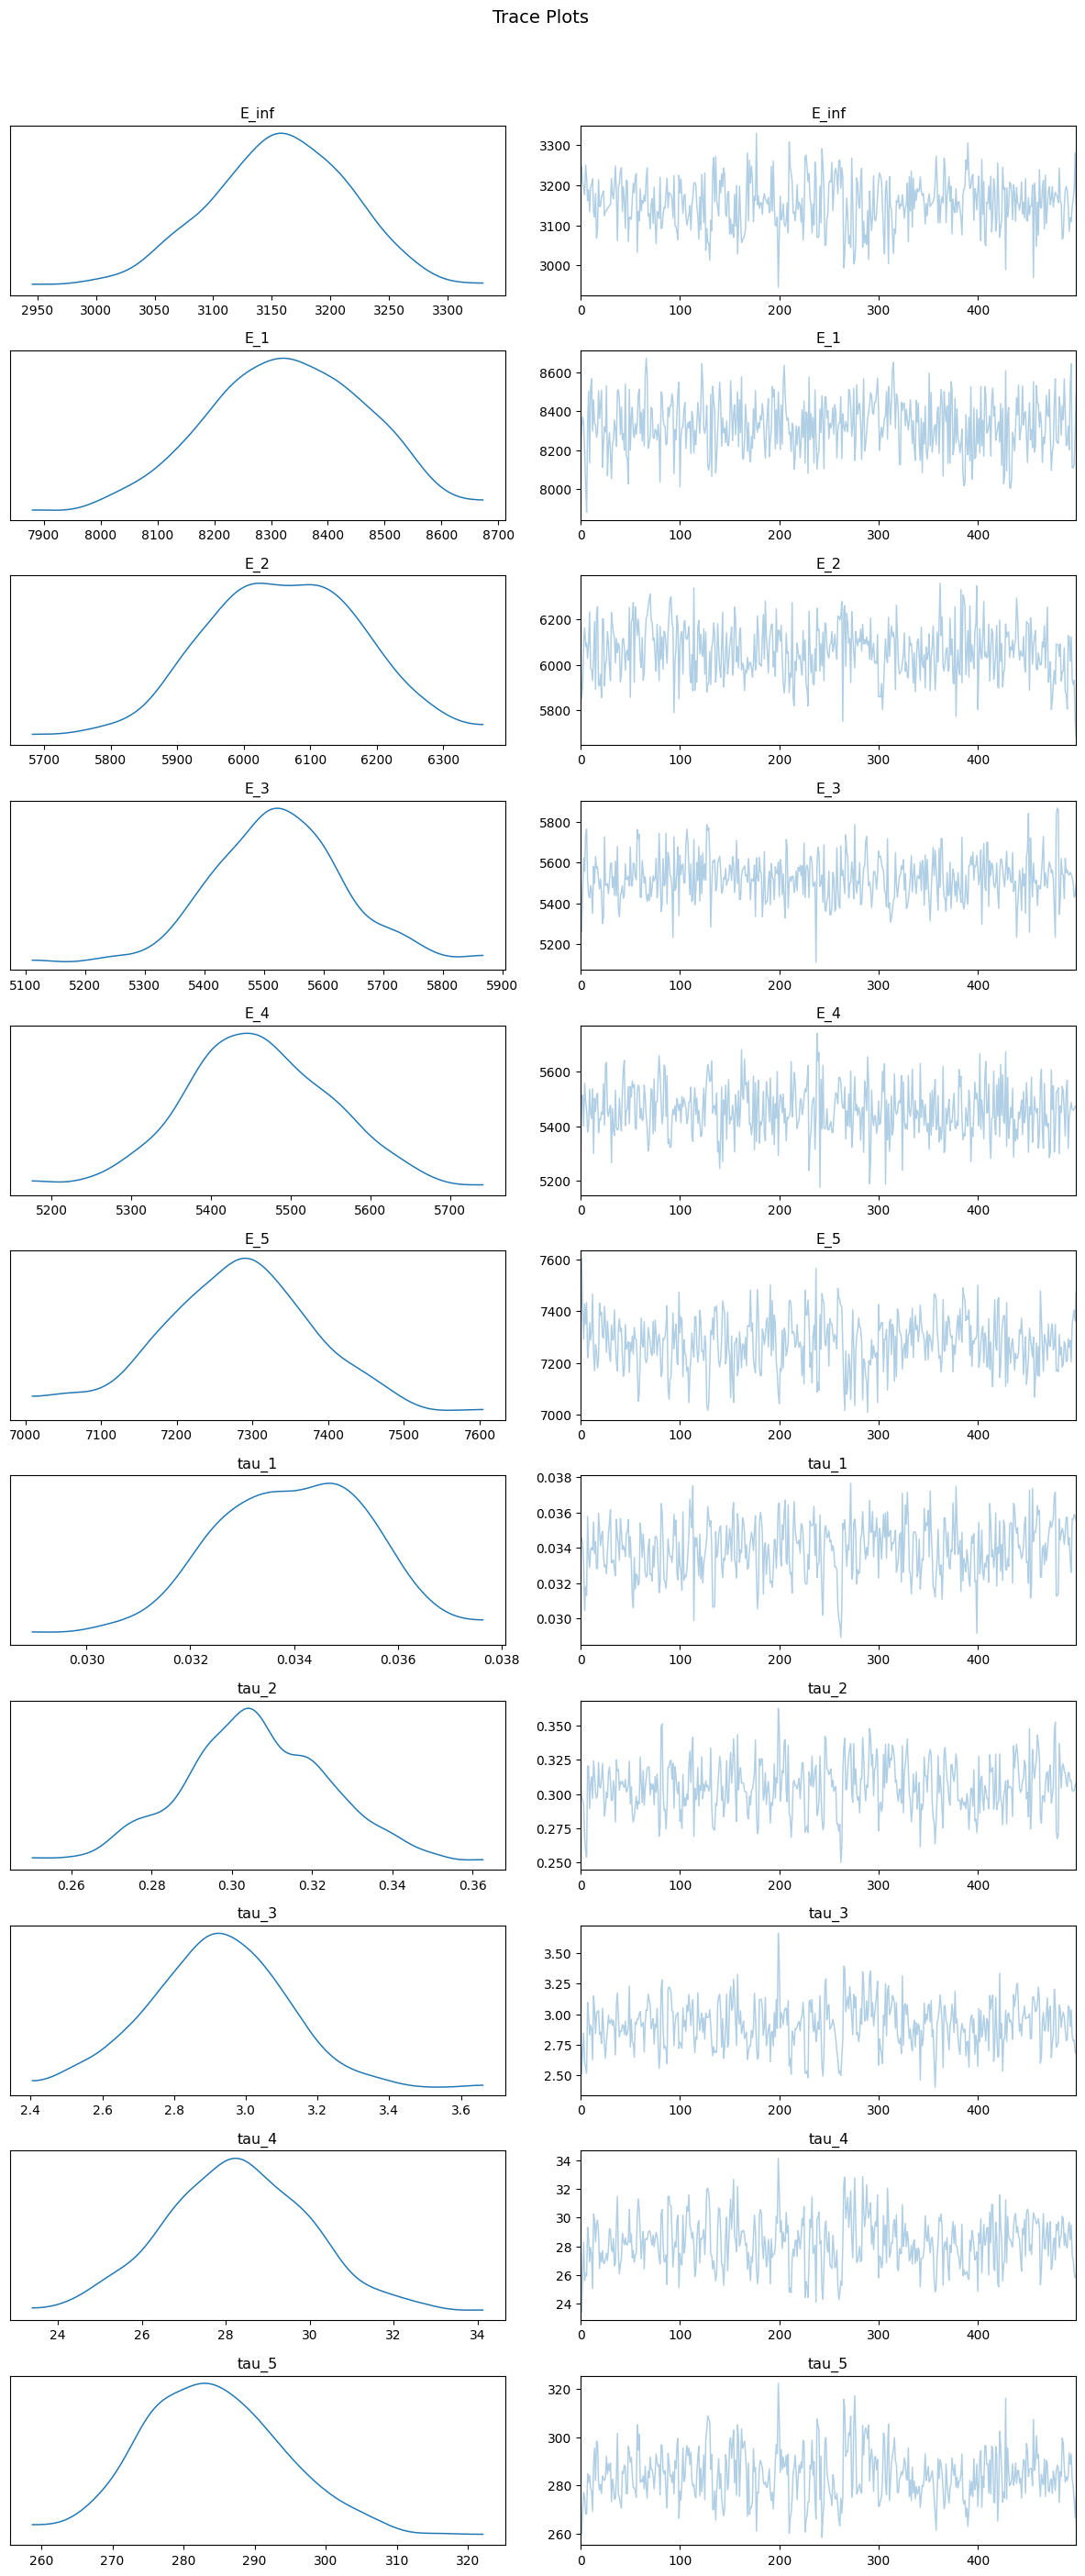

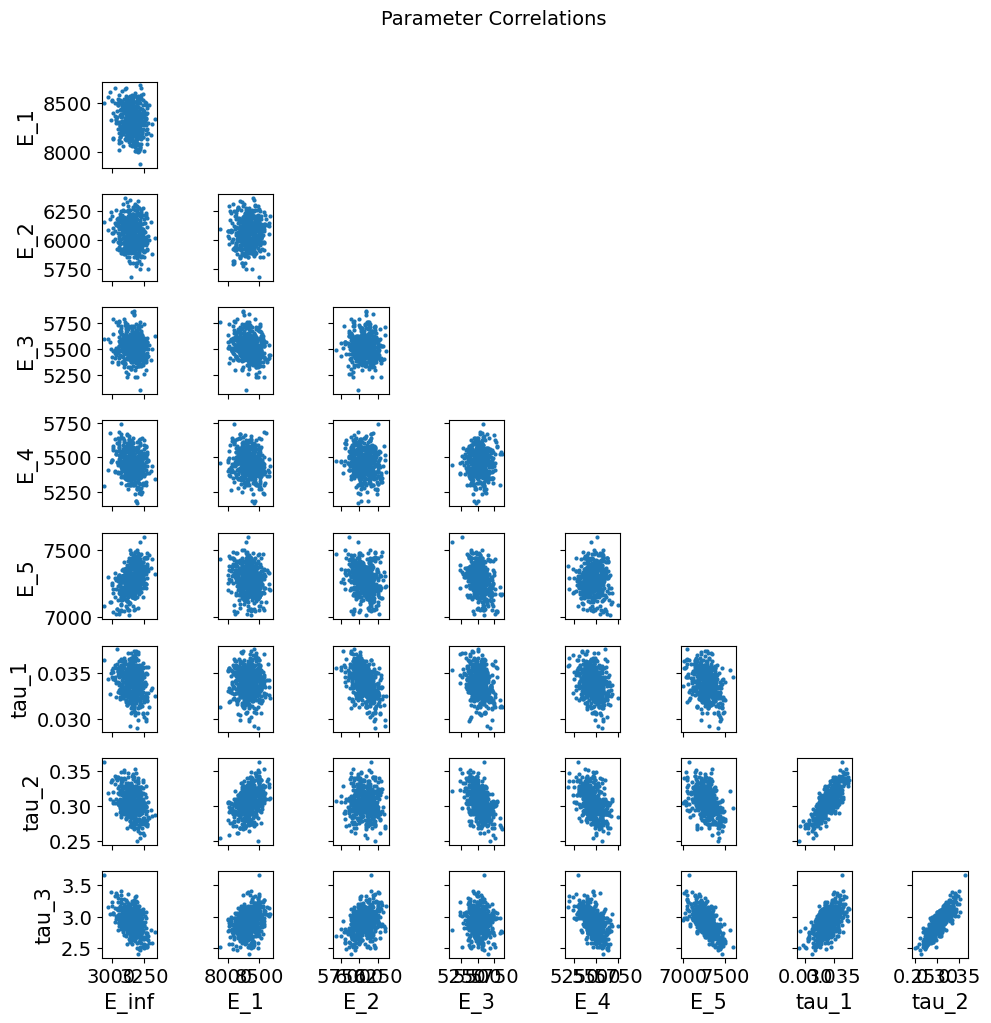

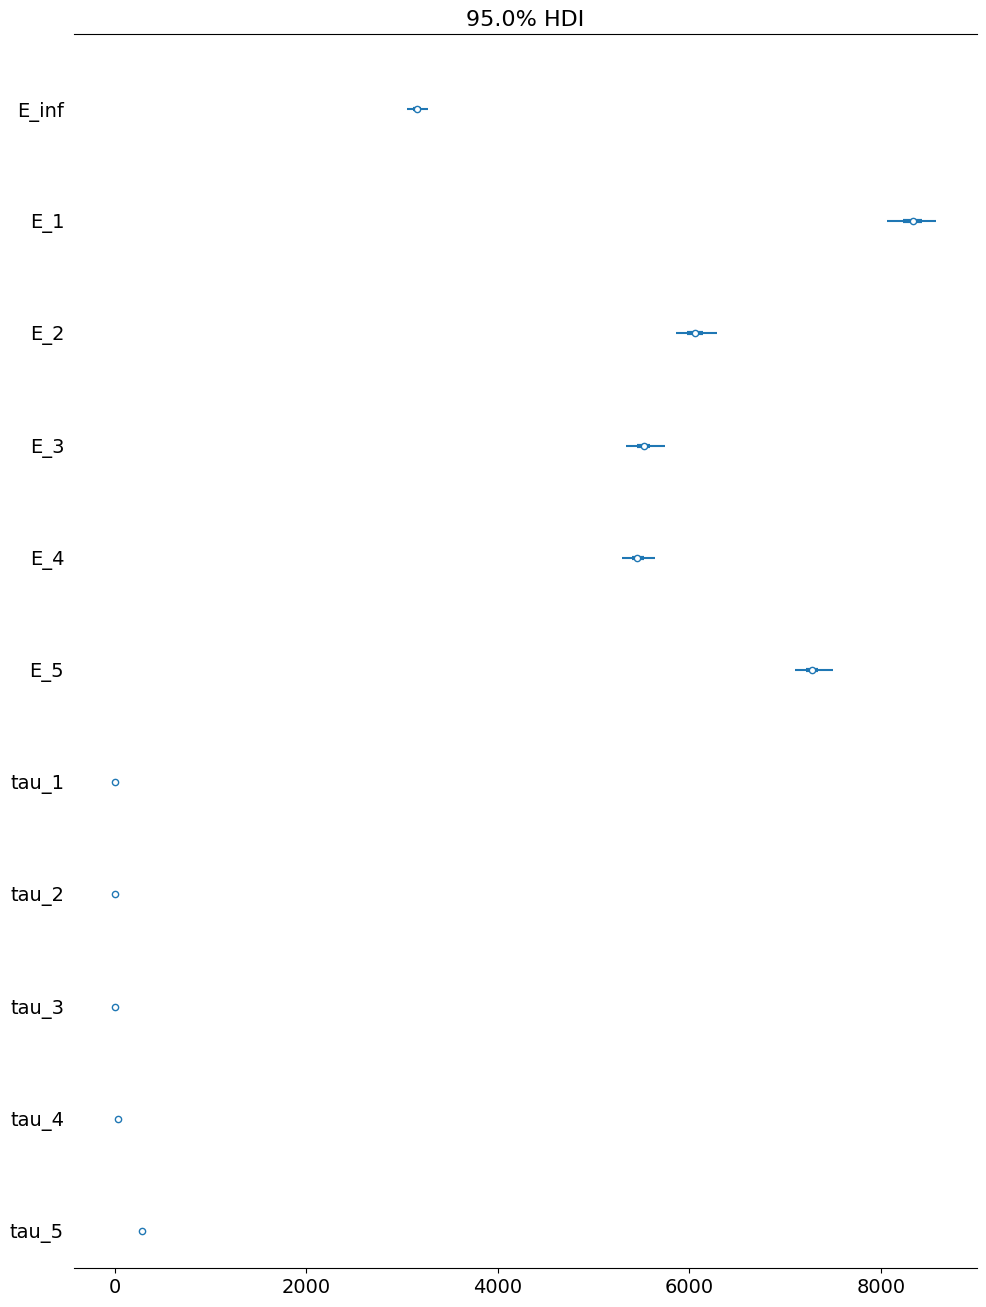

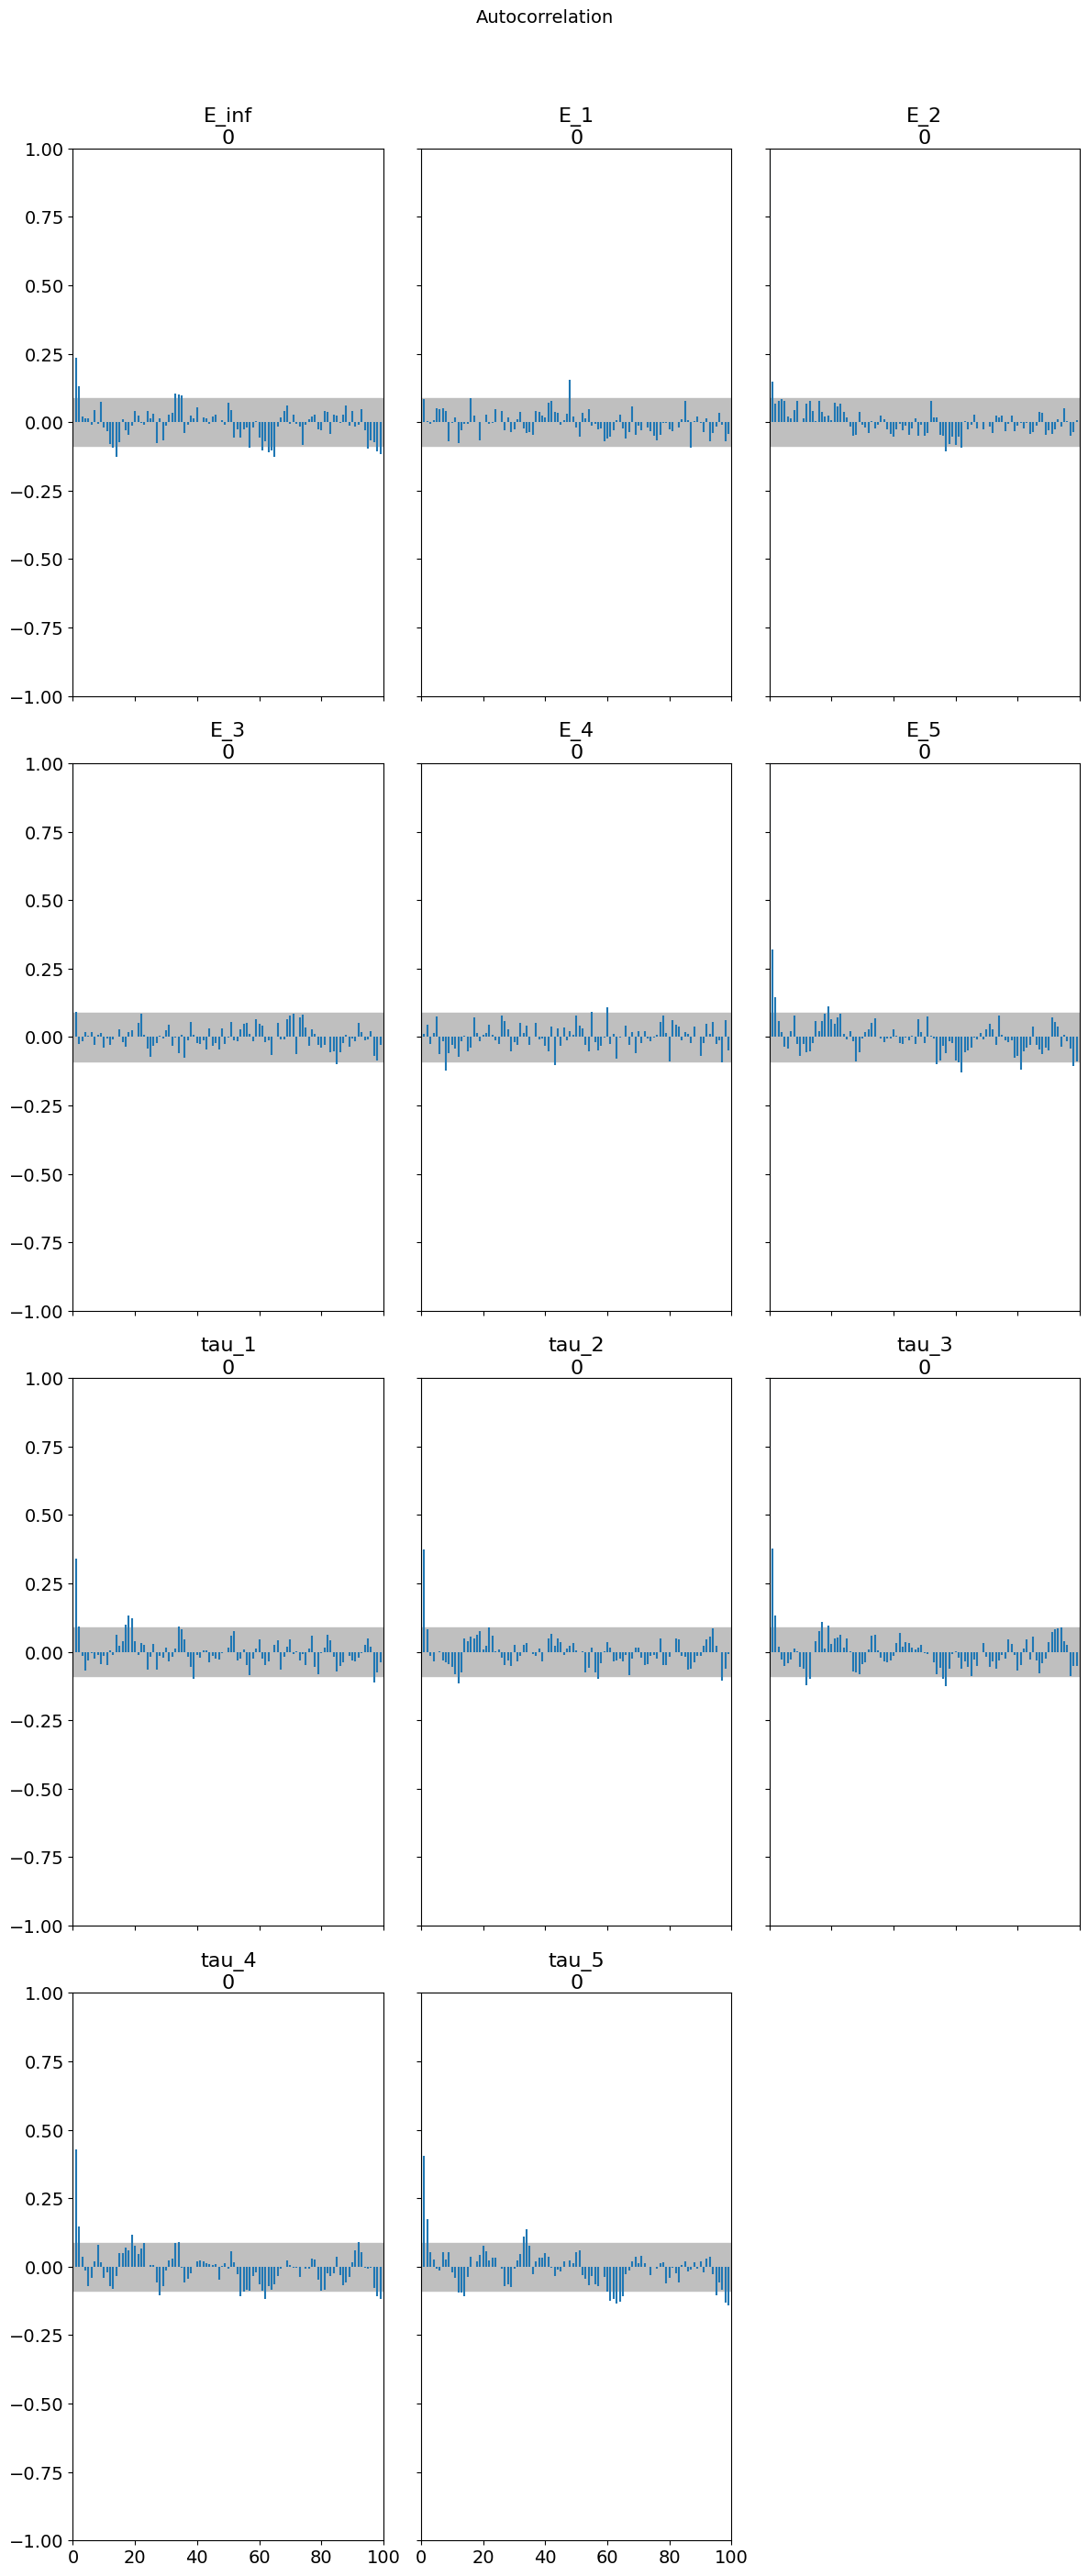

In [10]:
# ArviZ diagnostics for Bayesian results
for ds_idx, (bayes_result, param_names) in bayes_results.items():
    print(f"\n--- Diagnostics for dataset {ds_idx} ---")
    display_arviz_diagnostics(bayes_result, param_names, fast_mode=True)
